# Appendix - HW 1 Krzysztof Jankowski

## Fetching the dataset and first analysis.

In [ ]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('pc1', return_X_y=True)
X.head()
print(X.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(1109, 21)


1032
77


,loc,v(g),ev(g),iv(G),N,V,L,D,I,E,...,T,lOCode,lOComment,locCodeAndComment,lOBlank,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1.109000e+03,...,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000
mean,23.376105,5.510730,2.766817,3.321371,117.393417,699.711217,0.129414,15.396267,32.904472,2.882288e+04,...,1601.273030,22.434626,4.696123,0.944995,6.745717,13.307665,20.892876,66.493417,50.901894,9.576555
std,35.284017,8.958976,5.567704,6.401998,197.336888,1509.545684,0.146952,16.337508,35.387685,1.706436e+05,...,9480.199989,33.574645,10.518447,3.345297,12.301210,8.182224,29.051434,111.703236,86.308689,16.540676
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,7.000000,1.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.710000,14.040000,5.581300e+02,...,31.010000,7.000000,0.000000,0.000000,1.000000,8.000000,6.000000,15.000000,10.000000,1.000000
50%,13.000000,3.000000,1.000000,2.000000,58.000000,275.100000,0.080000,11.610000,23.570000,3.189170e+03,...,177.180000,13.000000,0.000000,0.000000,2.000000,12.000000,12.000000,33.000000,24.000000,5.000000
75%,26.000000,6.000000,3.000000,3.000000,126.000000,674.040000,0.160000,20.500000,41.150000,1.238156e+04,...,687.860000,24.000000,5.000000,1.000000,8.000000,17.000000,25.000000,72.000000,56.000000,11.000000
max,602.000000,136.000000,123.000000,123.000000,2785.000000,25942.690000,2.000000,270.660000,598.330000,4.279633e+06,...,237757.400000,600.000000,159.000000,48.000000,225.000000,99.000000,538.000000,1641.000000,1144.000000,236.000000


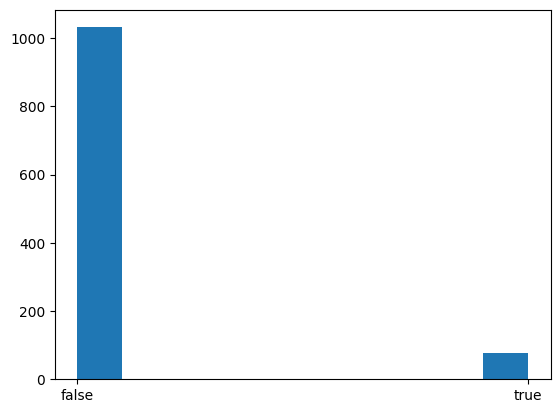

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(y)

print(np.sum(y == 'false'))
print(np.sum(y == 'true'))

X.describe()

## Data split and testing models.

In [ ]:
!pip install tabpfn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

standard_scaler = StandardScaler()

default_models = {
    'logistic_regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'random_forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'xgboost': XGBClassifier(random_state=42, n_jobs=-1),
    'tabpfn': TabPFNClassifier(device='cpu', N_ensemble_configurations=2),
}

scaler_dict = {
    'logistic_regression': standard_scaler,
    'random_forest': standard_scaler,
    'xgboost': standard_scaler,
    'tabpfn': None,
}

grids = {
    'logistic_regression': dict(solver=['liblinear', 'lbfgs'], penalty=['none', 'l2'], C=[100, 10, 1.0, 0.1, 0.01]),
    'random_forest': dict(n_estimators=[1, 2, 10, 50, 100], max_depth=[2, 10, 50, None]),
    'xgboost': dict(max_depth=[1, 2, 6, 10], eta=[1, 0.3, 0.1], alpha=[1, 0]),
    # 'tabpfn': dict(N_ensemble_configurations=[2, 16, 32]), # Gives memory leak error in gridsearch and takes too much resources.
}

models_dict = {
    'logistic_regression': LogisticRegression,
    'random_forest': RandomForestClassifier,
    'xgboost': XGBClassifier,
    'tabpfn': TabPFNClassifier,
}

def benchmark_models(models, metric):
    for name, model in models.items():
        standard_scaler = scaler_dict[name]
        pipe = Pipeline(steps=[('scaler', standard_scaler), ('classifier', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        bac: float = metric(y_test, y_pred)
        print(f'{name}: {bac:.3f}')

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

for s in [None, y]:
    print('Splitting data with stratify=y' if s is not None else 'Splitting data with stratify=None')

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=s)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    print(
        f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

    benchmark_models(default_models, balanced_accuracy_score)

    print('Starting gridSearch')
    optimized_models = {}
    for name, model in default_models.items():
        if name not in grids:
            continue
        grid = grids[name]
        cv = RepeatedStratifiedKFold(n_splits=3, random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',
                                   error_score=0)
        grid_result = grid_search.fit(X_train, y_train)
        # summarize results
        print(f'{name}: Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}')

        optimized_models[name] = models_dict[name](random_state=42, **grid_result.best_params_)

    print('Benchmarking models after grid search')
    benchmark_models(optimized_models, balanced_accuracy_score)

Splitting data with stratify=None
X_train shape: (887, 21), y_train shape: (887,), X_test shape: (222, 21), y_test shape: (222,)
logistic_regression: 0.548
random_forest: 0.548
xgboost: 0.598
tabpfn: 0.579
Starting gridSearch


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 71, in _check_solver
    raise ValueError("penalty='none' i

logistic_regression: Best: 0.577 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
random_forest: Best: 0.637 using {'max_depth': 10, 'n_estimators': 1}
xgboost: Best: 0.638 using {'alpha': 0, 'eta': 0.3, 'max_depth': 10}
Benchmarking models after grid search
logistic_regression: 0.498
random_forest: 0.612
xgboost: 0.593
Splitting data with stratify=y
X_train shape: (887, 21), y_train shape: (887,), X_test shape: (222, 21), y_test shape: (222,)
logistic_regression: 0.529
random_forest: 0.659
xgboost: 0.724
tabpfn: 0.600
Starting gridSearch


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 71, in _check_solver
    raise ValueError("penalty='none' i

logistic_regression: Best: 0.576 using {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'}
random_forest: Best: 0.610 using {'max_depth': 10, 'n_estimators': 1}
xgboost: Best: 0.626 using {'alpha': 0, 'eta': 1, 'max_depth': 6}
Benchmarking models after grid search
logistic_regression: 0.562
random_forest: 0.578
xgboost: 0.786


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
